# Setting up the environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import Imputer
import copy
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.tools.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# The refugee dataset is being imported as a dataframe

In [2]:
data = pd.read_excel(r'G:\MS sem 2\Data science lab\datasets\filtered_one.xlsx',index_col='Date', parse_dates=['Date'])
data

,Arrivals to Italy,Arrivals to Greek Islands,Departures to mainland Greece,Arrivals to fYRoM,Arrivals to Serbia,Arrivals to Croatia,Arrivals to Hungary,Arrivals to Slovenia,Arrivals to Austria
Date,,,,,,,,,
2015-10-01,343,2631,2409,4370,5900.0,4344,3667.0,0.0,4550
2015-10-02,0,4055,1215,5853,3700.0,5546,4897.0,0.0,2700
2015-10-03,128,6097,4480,4202,3700.0,6086,6056.0,NaN,7100
2015-10-04,62,4763,1513,5181,4250.0,5065,5925.0,0.0,5800
2015-10-05,0,5909,7833,4282,3250.0,6338,5952.0,0.0,6100
2015-10-06,2001,6496,6707,4156,2650.0,6370,6000.0,NaN,5800
2015-10-07,1010,3734,4886,7816,4350.0,4446,6103.0,0.0,5861
2015-10-08,0,4295,5349,7663,4650.0,7798,4583.0,6.0,4229
2015-10-09,572,5695,2631,6107,6550.0,8201,7215.0,0.0,6700


# Analysis of the data 

Text(0.5,0,'Months')

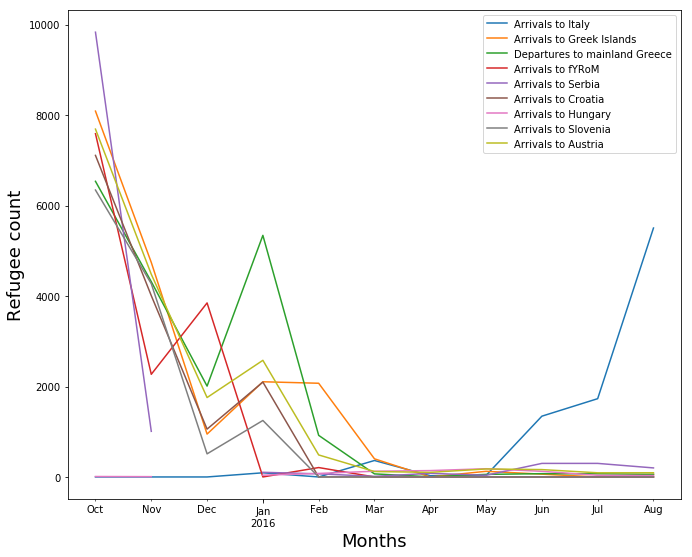

In [3]:
rcParams['figure.figsize'] = 11, 9
data.asfreq('M').plot()
plt.ylabel('Refugee count', fontsize=18)
plt.xlabel('Months', fontsize=18)

# Interpolation to fill the missing values

In [10]:
# To check if there are any null values in the dataset
data.isnull().sum()   

Arrivals to Italy                0
Arrivals to Greek Islands        0
Departures to mainland Greece    0
Arrivals to fYRoM                0
Arrivals to Serbia               1
Arrivals to Croatia              0
Arrivals to Hungary              1
Arrivals to Slovenia             4
Arrivals to Austria              0
dtype: int64

# Linear Interpolation

In [4]:
def linear_interpolation (country):
    linear_interpolated_data = country.interpolate(method='linear')
    return (linear_interpolated_data)

# IDW Interpolation

In [5]:
def idw_interpolation_k_factor(country,factor):
    
    dates = country.index.to_series()
    arrivals = country.iloc[:]
    location = []
    loc = []

    ind = pd.Index(arrivals)
    
    cnt = 0

    boolean_value = arrivals.isna()
    
    for i in boolean_value:
        if i==True: cnt+=1
        
    if cnt>0:
            location = np.append(loc, ind.get_loc(np.nan))

            weights = []
            indexes = list(range(len(dates)))

            for k in range (0, len(location)):
                numerator = []
                shift_index = indexes[:] - (location[k])

                for i in range(0,len(shift_index)-1):
                    if shift_index[i]<0:
                        shift_index[i]=shift_index[i]*(-1)


                for i in range(0,len(shift_index)):
                    if shift_index[i]!=0:
                        shift_index[i] = 1 / (shift_index[i]**factor)


                for i in range(0,len(shift_index)):
                    if shift_index[i]!=0:
                        numerator = np.append(numerator, (ind[i] * shift_index[i]))
                    else:
                         numerator = np.append(numerator,0)

                denominator = shift_index
                weights.append(np.nansum(numerator) // np.nansum(denominator))

   
            
            count = 0
            for item in location:
                if(count < len(weights)):
                    country.iloc[int(item)] = weights[count]
                    count += 1

    return country

# Interpolating the missing data using IDW interpolation

Three countries have no entries in the dataset. Hence IDW interpolation is used to fill those missing values. 

In [6]:
interpolated_data = copy.deepcopy(data)
interpolated_data_2 = copy.deepcopy(data)
for country in data.columns:
    interpolated_data[country] = idw_interpolation_k_factor(data[country], 1) # k-value is taken as 1. 
    interpolated_data_2[country] = idw_interpolation_k_factor(data[country], 2) # k-values is taken as 2.

In [19]:
interpolated_data.isnull().sum()   # All the missing data is being filled with approximated values using IDW interpolation.

Arrivals to Italy                0
Arrivals to Greek Islands        0
Departures to mainland Greece    0
Arrivals to fYRoM                0
Arrivals to Serbia               0
Arrivals to Croatia              0
Arrivals to Hungary              0
Arrivals to Slovenia             0
Arrivals to Austria              0
dtype: int64

# Comparison of IDW-1, IDW-3 and linear interpolation using RMSE error

Here evaluation procedure is carried out by manually removing two random entries from the dataset for all the countries. Then, 
IDW and Linear Interpolation techniques are applied to check the accuracy of both the methods.

In [9]:
rmse_data = copy.deepcopy(interpolated_data)
rmse_data_2 = copy.deepcopy(rmse_data)
original_data = copy.deepcopy(interpolated_data)
rmse_IDW = []
rmse_IDW_2 = []
rmse_linear = []
idw_interpolated_data = copy.deepcopy(interpolated_data)
idw_interpolated_data_2 = copy.deepcopy(interpolated_data)

for item in interpolated_data.columns:
    rmse_data[item]['2015-11-10'] = np.nan
    rmse_data[item]['2016-09-12'] = np.nan


for item in interpolated_data_2.columns:
    rmse_data_2[item]['2015-11-10'] = np.nan
    rmse_data_2[item]['2016-09-12'] = np.nan

rmse_data_lin = copy.deepcopy(rmse_data)

for item in rmse_data.columns:
    idw_interpolated_data[item] = idw_interpolation_k_factor(rmse_data[item],1)
    idw_interpolated_data_2[item] = idw_interpolation_k_factor(rmse_data_2[item],3)

linear_interpolated_data = linear_interpolation(rmse_data_lin)


for item in data.columns:
    rmse_IDW.append(math.sqrt(mean_squared_error(original_data[item], idw_interpolated_data[item])))
    rmse_IDW_2.append(math.sqrt(mean_squared_error(original_data[item], idw_interpolated_data_2[item])))
    rmse_linear.append(math.sqrt(mean_squared_error(original_data[item], linear_interpolated_data[item])))

    
countries = interpolated_data.columns
models = ['IDW-1','IDW-3','Linear']
df_results = pd.DataFrame(columns = models, index = countries)


count = 0
for item in countries:
    df_results.loc[item] = rmse_IDW[count], rmse_IDW_2[count], rmse_linear[count]
    count+= 1

print ('Average RMSE values for all countries : \n\n IDW interpolation factor 1 = %f \n IDW interpolation factor 3 = %f \n Linear interpolation = %f' %(np.mean(df_results['IDW-1']), np.mean(df_results['IDW-3']), np.mean(df_results['Linear'])))
df_results

Average RMSE values for all countries : 

 IDW interpolation factor 1 = 110.190072 
 IDW interpolation factor 3 = 35.667720 
 Linear interpolation = 39.222686


,IDW-1,IDW-3,Linear
Arrivals to Italy,109.159,117.716,119.006
Arrivals to Greek Islands,43.8166,34.4686,37.6379
Departures to mainland Greece,74.1171,85.6968,107.577
Arrivals to fYRoM,201.326,3.01676,16.2217
Arrivals to Serbia,202.181,16.0894,5.79535
Arrivals to Croatia,118.594,8.36225,5.55719
Arrivals to Hungary,16.5584,0.285013,0.27628
Arrivals to Slovenia,141.002,52.9785,53.4284
Arrivals to Austria,84.956,2.39631,7.50471


# Time Series decomposition for Slovenia

The original time series can be decomposed into Trend, Seasonal and Residual components to observe the stationarity of the time series data

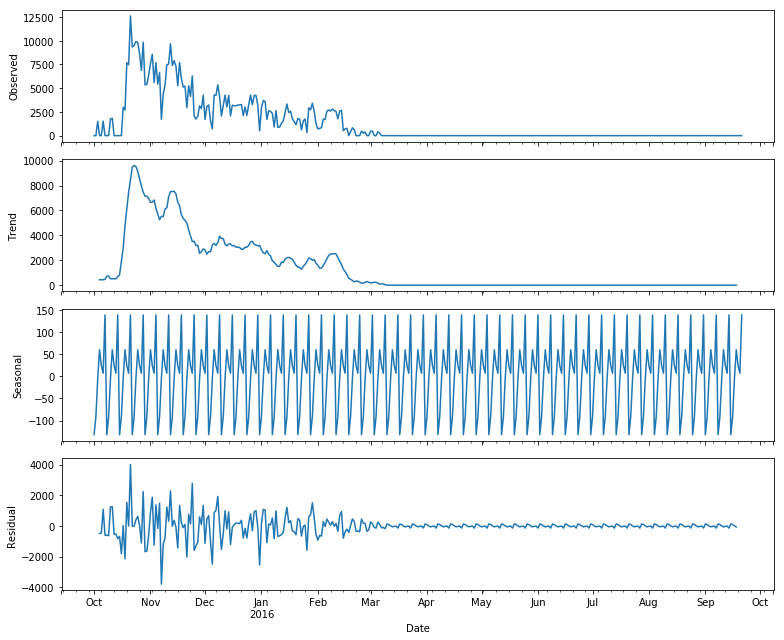

In [57]:
rcParams['figure.figsize'] = 11, 9
data_Slovenia = data[['Arrivals to Slovenia']]
decomposed_Slovenia = sm.tsa.seasonal_decompose(data_Slovenia)
figure = decomposed_Slovenia.plot()
plt.show()

# Augmented Dickey Fuller test

In [5]:
def dickey_fuller(country):
    
    dftest = adfuller(country, autolag='AIC')
    df = pd.Series(dftest[0:4], index=['Test Statistic','P-Value','#Lags used','Number of observation used'])
    for key,value in dftest[4].items():
        df['Critical values (%s)'%key] = value
    print ('Dickey Fuller test results: \n')
    print (df)

# Function to check stationarity

In [6]:
def check_stationarity(country):
    
    rol_mean = country.rolling('90D').mean()
    rol_std = country.rolling('90D').std()
    country.plot()
    rol_mean.plot()
    rol_std.plot()
    plt.legend(['Original series','Rolling mean','Rolling standard deviation'])
    plt.title('Rolling mean and rolling standard deviation plot')
    plt.show()

# To check stationarity of the time series (for Italy)

The country Italy is stationary time series since p-value < 0.05.
Rolling Mean and Standard deviation plot is also constant with respect to time.

Dickey Fuller test results: 

Test Statistic               -8.677227e+00
P-Value                       4.382857e-14
#Lags used                    1.000000e+00
Number of observation used    3.550000e+02
Critical values (1%)         -3.448906e+00
Critical values (5%)         -2.869716e+00
Critical values (10%)        -2.571126e+00
dtype: float64


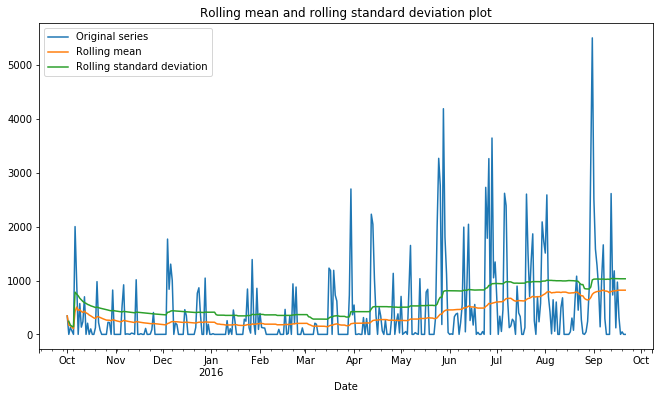

In [10]:
rcParams['figure.figsize'] = 11, 6
dickey_fuller(interpolated_data['Arrivals to Italy'])
check_stationarity(interpolated_data['Arrivals to Italy'])

# Trend and Seasonal plot for Italy

From Trend and Seasonal plot, we can observe that the country Italy exhibits some trend patterns. However, it can be confirmed from the Augmented Dickey Fuller test and Rolling mean and standard deviation plot that Italy is stationary time series. 

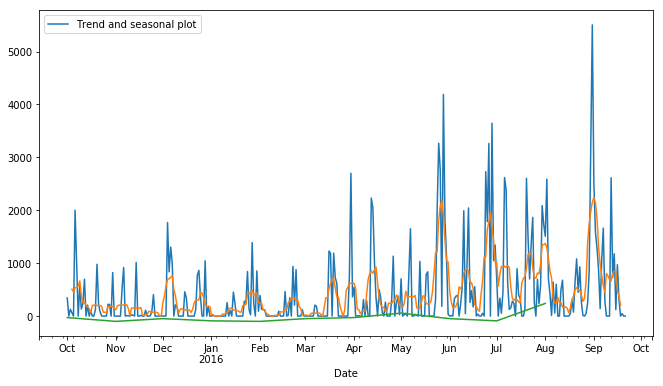

In [63]:
interpolated_data['Arrivals to Italy'].plot()
plt.legend(['Original plot'])

decomposed_data = sm.tsa.seasonal_decompose(interpolated_data['Arrivals to Italy'])
decomposed_data.trend.plot()
plt.legend(['Trend plot'])

decomposed_data.seasonal.asfreq('M').plot()
plt.legend(['Trend and seasonal plot'])

plt.show()

# Non-stationary time series (For the country Austria)

The country Austria is non-stationary time series since p-value > 0.05. Rolling Mean and Standard deviation plot is also varying with respect to time.

Dickey Fuller test results: 

Test Statistic                 -1.977712
P-Value                         0.296430
#Lags used                     13.000000
Number of observation used    343.000000
Critical values (1%)           -3.449560
Critical values (5%)           -2.870004
Critical values (10%)          -2.571279
dtype: float64


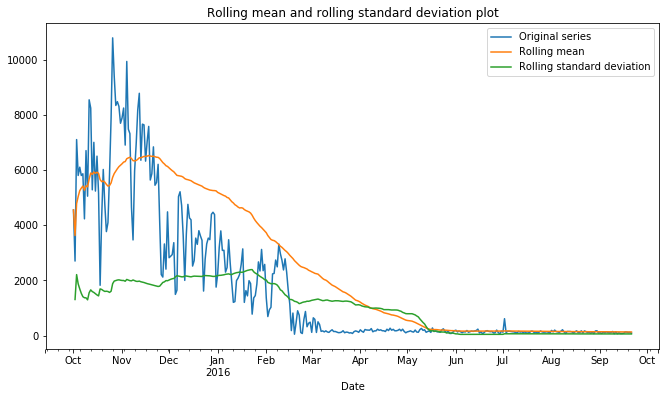

In [11]:
rcParams['figure.figsize'] = 11, 6
dickey_fuller(interpolated_data['Arrivals to Austria'])
check_stationarity(interpolated_data['Arrivals to Austria'])

# To check periodicity of the seasonal component

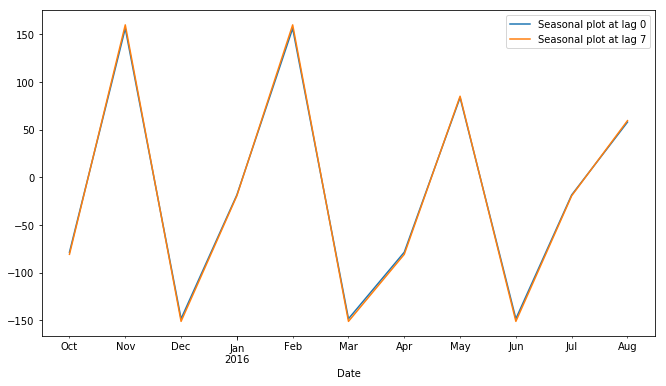

In [106]:
decomposed_data = sm.tsa.seasonal_decompose(interpolated_data['Arrivals to Austria'])
decomposed_data_7 = sm.tsa.seasonal_decompose(interpolated_data['Arrivals to Austria'].shift(7)[7:])

decomposed_data.seasonal.asfreq('M').plot()
decomposed_data_7.seasonal.asfreq('M').plot()
plt.legend(['Seasonal plot at lag 0','Seasonal plot at lag 7'])
plt.show()

# Trend and Seasonal plot for "Austria" before performing Difference Transform

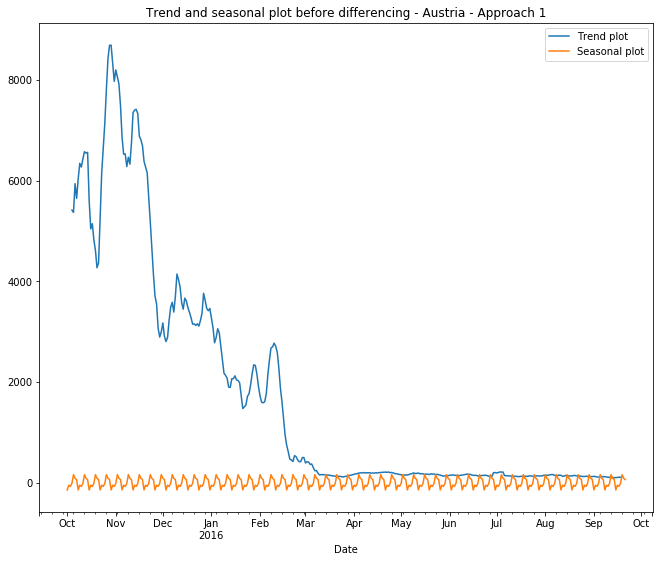

In [31]:
decomposed_data = sm.tsa.seasonal_decompose(interpolated_data['Arrivals to Austria'])
decomposed_data.trend.plot()
decomposed_data.seasonal.plot()
plt.title('Trend and seasonal plot before differencing - Austria - Approach 1')
plt.legend(['Trend plot','Seasonal plot'])
plt.show()

# Differencing - APPROACH - 1

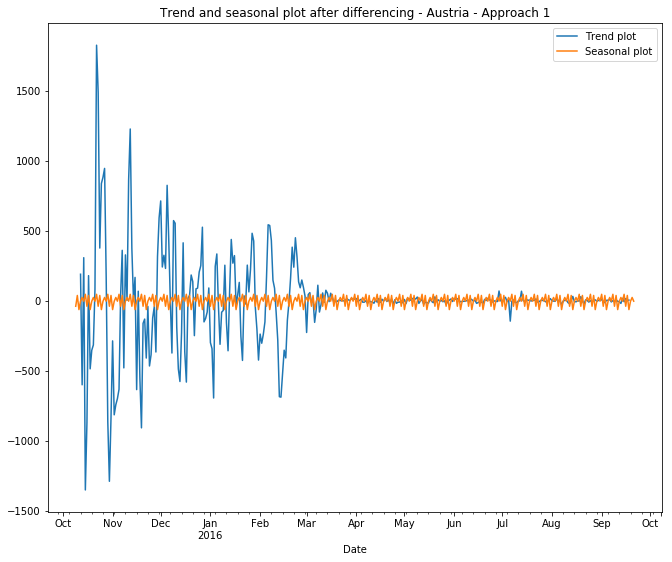

In [30]:
detrend = interpolated_data['Arrivals to Austria'].diff(1).dropna()
diff = detrend.diff(7).dropna()
decomposed_data = sm.tsa.seasonal_decompose(diff)
decomposed_data.trend.plot()
decomposed_data.seasonal.plot()
plt.title('Trend and seasonal plot after differencing - Austria - Approach 1')
plt.legend(['Trend plot','Seasonal plot'])
plt.show()

# Difference Transform - APPROACH - 2

In [8]:
def difference_transform(country):
    
    de_trend = (country - country.rolling(window=7).mean()) /country.rolling(window=7).std()
    de_trend = de_trend.dropna()
    de_trend_season = de_trend - de_trend.shift(7)
    de_trend_season = de_trend_season.dropna()
    return de_trend_season

# Difference Transform for non-stationary data for the remaining 8 countries

In [9]:
# Creating a new dataframe for storing differenced series having same column names and index.
differenced_series = pd.DataFrame(columns = interpolated_data.columns, index = interpolated_data.index)



# Difference Transform is done for all the 8 countries except "Italy"

for country in interpolated_data.columns:
    if country != 'Arrivals to Italy': 
        differenced_series[country] = difference_transform(interpolated_data[country])
        differenced_series[country] = differenced_series[country].dropna()
    else:
        differenced_series[country] = interpolated_data[country]
        differenced_series[country] = differenced_series[country].dropna()

In [12]:
differenced_series.dropna()  # Results of 1st order Differenced series for Approach 1

,Arrivals to Italy,Arrivals to Greek Islands,Departures to mainland Greece,Arrivals to fYRoM,Arrivals to Serbia,Arrivals to Croatia,Arrivals to Hungary,Arrivals to Slovenia,Arrivals to Austria
Date,,,,,,,,,
2015-10-14,207,2.108530,-0.046926,-2.543531,-0.775902,-0.185617,-1.815710,-0.001170,0.028625
2015-10-15,0,1.947968,-0.574811,-1.162951,-1.110771,-2.561918,0.212211,-0.006308,-0.137252
2015-10-16,102,1.262416,2.434403,1.343191,-1.787795,-1.943720,-1.954970,0.001825,-0.871546
2015-10-17,0,2.276399,0.354518,-0.107251,-1.349758,-0.088762,-3.486178,0.287262,-0.229217
2015-10-18,0,1.779895,0.456214,2.392058,1.214036,-0.422483,-2.599673,0.145995,-3.717075
2015-10-19,125,0.514228,-1.274240,-0.521116,-1.713433,-1.385394,-2.381354,2.803615,-1.630165
2015-10-20,979,-0.250643,1.911391,0.537930,-0.545692,2.488708,-0.867401,1.913130,1.111823
2015-10-21,219,-0.646906,1.391663,1.531140,0.758766,2.985593,0.538527,2.268048,-0.401567
2015-10-22,76,-2.831869,0.469422,0.869410,0.889480,1.418341,1.045047,1.319270,0.379742


# Rolling mean and standard deviation plot for Austria before andafter differencing.
### It can be observed that after differencing, the rolling mean and standard deviation is constant over time.

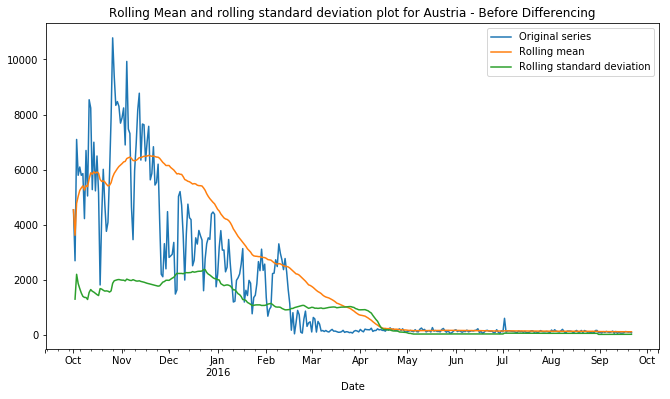

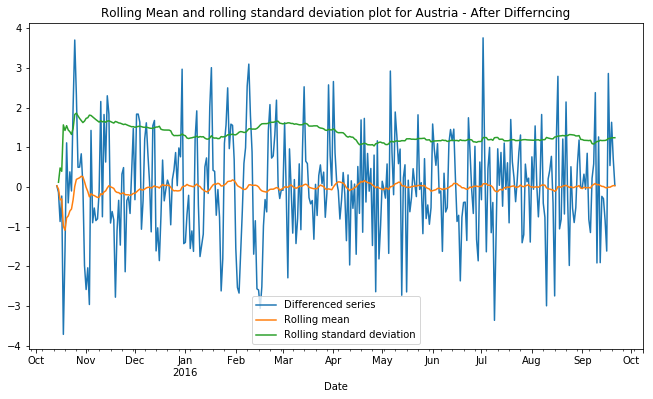

In [40]:
interpolated_data['Arrivals to Austria'].plot()
interpolated_data['Arrivals to Austria'].rolling('60D').mean().plot()
interpolated_data['Arrivals to Austria'].rolling('60D').std().plot()
plt.legend(['Original series','Rolling mean','Rolling standard deviation'])
plt.title('Rolling Mean and rolling standard deviation plot for Austria - Before Differencing')
plt.show()



differenced_series['Arrivals to Austria'].plot()
differenced_series['Arrivals to Austria'].rolling('60D').mean().plot()
differenced_series['Arrivals to Austria'].rolling('60D').std().plot()
plt.legend(['Differenced series','Rolling mean','Rolling standard deviation'])
plt.title('Rolling Mean and rolling standard deviation plot for Austria - After Differncing')
plt.show()


# Augmented Dickey fuller test for Austria - After Differencing
It can be seen that from Dickey fuller test, p-value has reduced form 0.29 to 1.81e-16 which is less than 0.05.

In [49]:
dickey_fuller(differenced_series['Arrivals to Austria'].dropna())

Dickey Fuller test results: 

Test Statistic               -9.610693e+00
P-Value                       1.815140e-16
#Lags used                    1.300000e+01
Number of observation used    3.300000e+02
Critical values (1%)         -3.450322e+00
Critical values (5%)         -2.870338e+00
Critical values (10%)        -2.571458e+00
dtype: float64


# Trend and Seasonal plot for "Austria" after Difference Transform
 As shown below, the trend and seasonal plot for Austria can be drawn for the rest of the countries to analyze the trend and 
 seasonality before and after differencing. The trend and seasonality is reduced to zero after difference transform

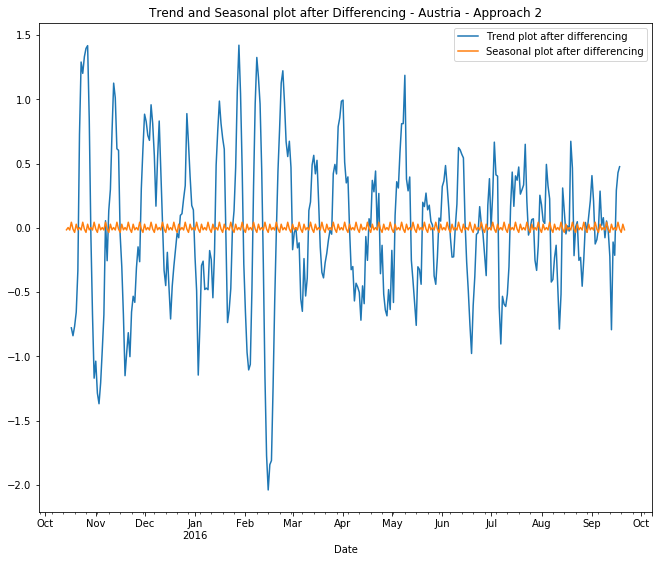

In [29]:
# Time series decomposition into trend, seasonality and Residual parts.
rcParams['figure.figsize'] = 11, 9
decomposed_data = sm.tsa.seasonal_decompose(interpolated_data['Arrivals to Austria'])
decomposed_data_diff = sm.tsa.seasonal_decompose(differenced_series['Arrivals to Austria'].dropna())


#interpolated_data['Arrivals to Austria'].plot()
#plt.legend(['Original series'])


# Extracting trend patterns from the decomposed series.
decomposed_data_diff.trend.plot()
# Extracting seasonal patterns from the decomposed series.
decomposed_data_diff.seasonal.plot()
plt.title('Trend and Seasonal plot after Differencing - Austria - Approach 2')
plt.legend(['Trend plot after differencing', 'Seasonal plot after differencing'])

plt.show()

# Rolling mean and standard deviation for "Austria" after 2nd order Difference Transform

2nd order Differencing is performed in order to check if we can stationarize it further. However there is no significant improvement in the data. Hence 2nd order differencing is discarded.

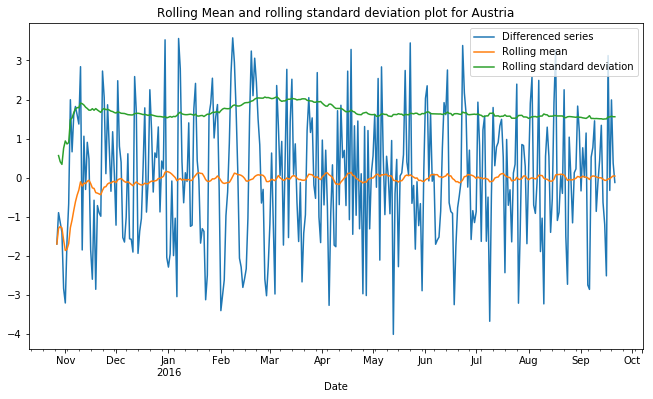

In [76]:
austria_order_2 = difference_transform(differenced_series['Arrivals to Austria'])

austria_order_2.plot()
austria_order_2.rolling('60D').mean().plot()
austria_order_2.rolling('60D').std().plot()
plt.legend(['Differenced series','Rolling mean','Rolling standard deviation'])
plt.title('Rolling Mean and rolling standard deviation plot for Austria')
plt.show()


# ACF and PACF plots - Austria

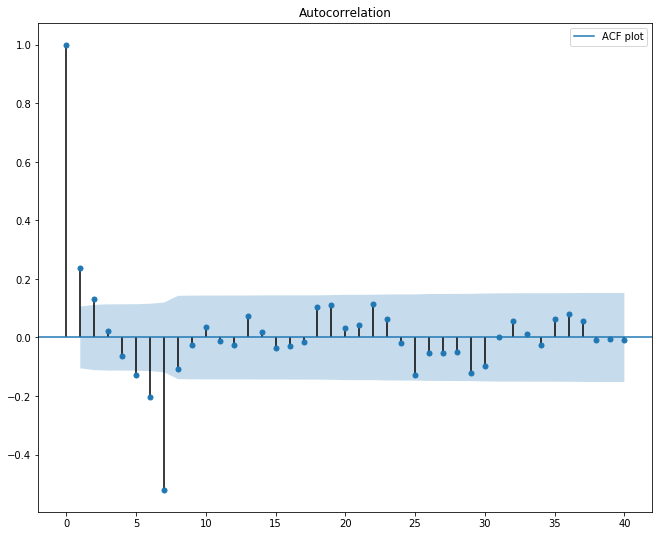

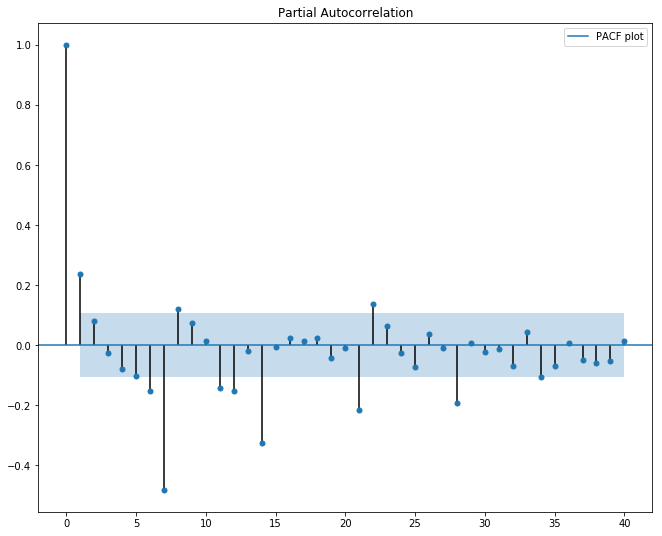

In [13]:
rcParams['figure.figsize'] = 11, 9
plot_acf(differenced_series['Arrivals to Austria'].dropna(), lags=40)
plt.legend(['ACF plot'])
plt.show()

plot_pacf(differenced_series['Arrivals to Austria'].dropna(), lags=40)
plt.legend(['PACF plot'])
plt.show()

# Heat Map model to check cross-correlation

From the heat map model we can observe the cross correlations from lag 1 to 4 between the countries <b> Arrivals to Greek Islands </b> and <b> Departures to Mainland Greece. </b> It can be observed that there is a significant cross-correlation of <b>41%</b> between Mainland Greece of lag 2 and Greek Islands of lag 1.

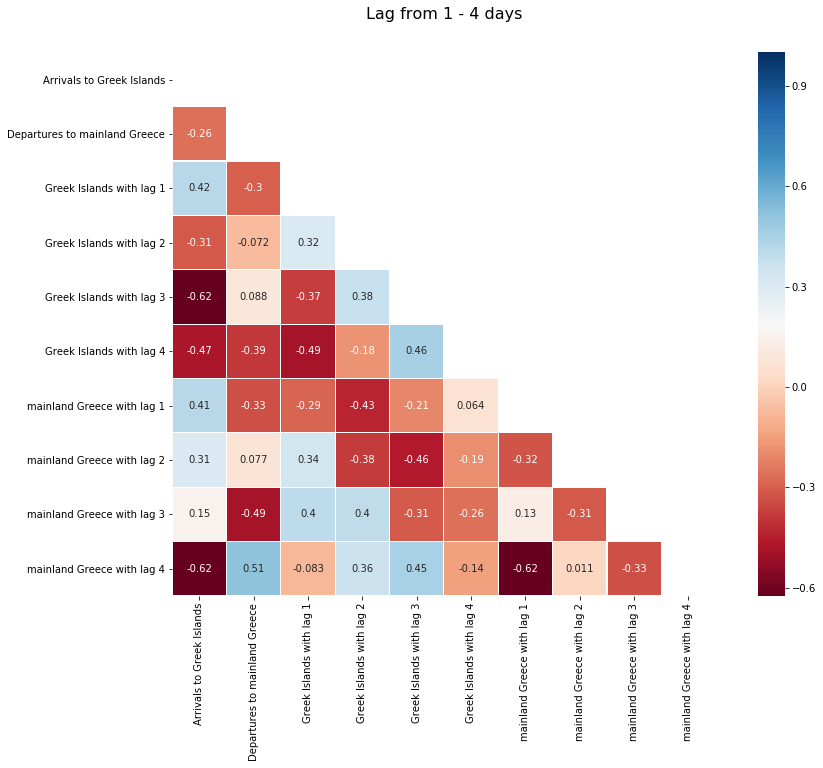

In [14]:
def cross_correlation_heatmap (name1, name2):
    country = differenced_series[[name1,name2]]
    for i in range(1,5):
        tt = differenced_series[name1][train_size:].shift(i)
        col = str(name1[12:]) + ' with lag ' + str(i)
        country[col] = tt

    for j in range(1,5):
        tt = differenced_series[name2][train_size:].shift(j)
        col = str(name2[14:]) +' with lag ' + str(j)
        country[col] = tt

    country = country.dropna()
    correlation = country.corr()
    
    colormap = plt.cm.RdBu
    plt.figure(figsize=(15,10))
    plt.title(u'Lag from 1 - 4 days', y=1.05, size=16)

    mask = np.zeros_like(correlation.corr())
    mask[np.triu_indices_from(mask)] = True

    svm = sns.heatmap(correlation.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)
    
    
    
    
train_size = int(len(differenced_series)*0.8)
cross_correlation_heatmap ('Arrivals to Greek Islands', 'Departures to mainland Greece')

## Heat map model between Greek Island and Hungary

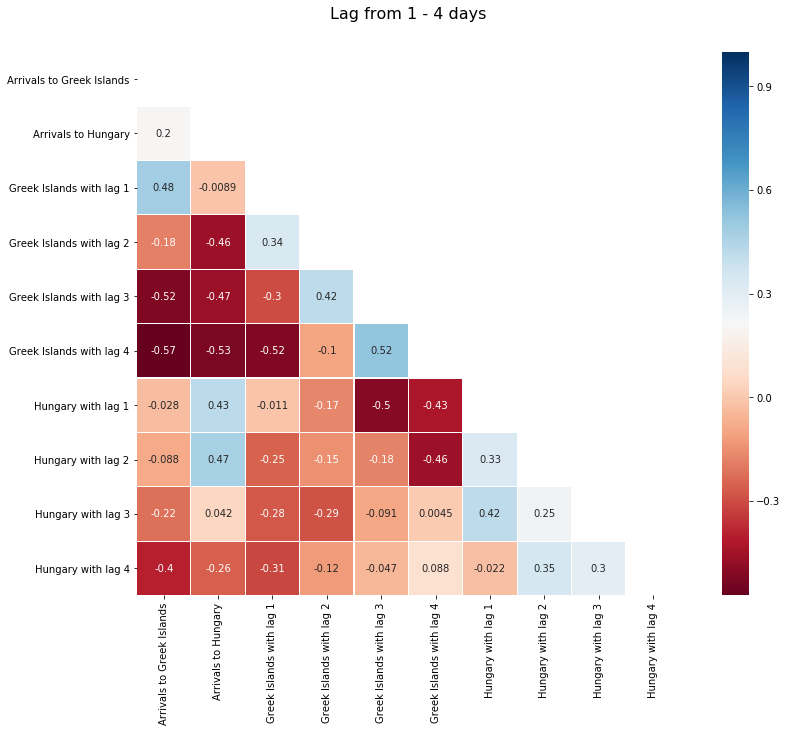

In [16]:
def cross_correlation_heatmap (name1, name2):
    country = differenced_series[[name1,name2]]
    for i in range(1,5):
        tt = differenced_series[name1][train_size:].shift(i)
        col = str(name1[12:]) + ' with lag ' + str(i)
        country[col] = tt

    for j in range(1,5):
        tt = differenced_series[name2][train_size:].shift(j)
        col = str(name2[12:]) +' with lag ' + str(j)
        country[col] = tt

    country = country.dropna()
    correlation = country.corr()
    
    colormap = plt.cm.RdBu
    plt.figure(figsize=(15,10))
    plt.title(u'Lag from 1 - 4 days', y=1.05, size=16)

    mask = np.zeros_like(correlation.corr())
    mask[np.triu_indices_from(mask)] = True

    svm = sns.heatmap(correlation.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)
    
    
    
    
train_size = int(len(differenced_series)*0.8)
cross_correlation_heatmap ('Arrivals to Greek Islands', 'Arrivals to Hungary')

# Correlations for all the countries

In [20]:
def find_correlations(data):
    c_original = []
    countries = data.columns    # To fetch all the 9 country names.
    max_country_list = []
    maximum = 0
    df = pd.DataFrame(columns = countries, index = countries)

    for item in countries:
        for item2 in countries:
            if (item != item2):
                correlation = interpolated_data[item][:68].corr(interpolated_data[item2][:68])
                df[item][item2] = correlation
                c_original.append(correlation)
                
                
                # To find which countries having maximum correlation between them
                if (correlation > maximum): 
                    maximum = correlation
                    max_country_list = [item, item2]

                    
    print ('Maximum correlation is: %f for the countries %s ' % (maximum, max_country_list))
    
    # Correlation between the same countries will be 1
    df.fillna(1)
    return df
    
    
find_correlations (interpolated_data)

Maximum correlation is: 0.877923 for the countries ['Arrivals to fYRoM', 'Arrivals to Serbia'] 


,Arrivals to Italy,Arrivals to Greek Islands,Departures to mainland Greece,Arrivals to fYRoM,Arrivals to Serbia,Arrivals to Croatia,Arrivals to Hungary,Arrivals to Slovenia,Arrivals to Austria
Arrivals to Italy,NaN,0.100851,0.0544528,-0.214827,-0.28528,-0.164656,0.148275,-0.164466,-0.0697113
Arrivals to Greek Islands,0.100851,NaN,0.484729,0.254353,0.266691,0.236453,0.0657016,0.192842,0.201476
Departures to mainland Greece,0.0544528,0.484729,NaN,0.444472,0.393103,0.184778,-0.0583298,0.249425,0.125019
Arrivals to fYRoM,-0.214827,0.254353,0.444472,NaN,0.877923,0.559777,-0.0224065,0.337199,0.250382
Arrivals to Serbia,-0.28528,0.266691,0.393103,0.877923,NaN,0.634506,-0.0771409,0.417456,0.289225
Arrivals to Croatia,-0.164656,0.236453,0.184778,0.559777,0.634506,NaN,0.0936095,0.536873,0.587598
Arrivals to Hungary,0.148275,0.0657016,-0.0583298,-0.0224065,-0.0771409,0.0936095,NaN,-0.659235,0.0795126
Arrivals to Slovenia,-0.164466,0.192842,0.249425,0.337199,0.417456,0.536873,-0.659235,NaN,0.404803
Arrivals to Austria,-0.0697113,0.201476,0.125019,0.250382,0.289225,0.587598,0.0795126,0.404803,NaN


## Adding a new column 'Total Balkan count'

In order to check the total number of refugees passing through the Balkon route, we have hypothesized that the total Balkon count on a particular day to be the sum of the refugee inflow count across all the countries for that corresponding day. This is achieved by adding a new column called <b>Total Balkon count</b>.

In [68]:
def add_total_balkon(country):
    total = []
    for j in range(0, len(country)):
        sum = 0
        for item in country.columns:
            sum += country[item].iloc[j]
        total.append(sum)
    return total
        
balkon_data = interpolated_data.copy()        
balkon_data['Total Balkon'] = add_total_balkon(interpolated_data)
balkon_data

,Arrivals to Italy,Arrivals to Greek Islands,Departures to mainland Greece,Arrivals to fYRoM,Arrivals to Serbia,Arrivals to Croatia,Arrivals to Hungary,Arrivals to Slovenia,Arrivals to Austria,Total Balkon
Date,,,,,,,,,,
2015-10-01,343,2631,2409,4370,5900.0,4344,3667.0,0.0,4550,28214.0
2015-10-02,0,4055,1215,5853,3700.0,5546,4897.0,0.0,2700,27966.0
2015-10-03,128,6097,4480,4202,3700.0,6086,6056.0,1497.0,7100,39346.0
2015-10-04,62,4763,1513,5181,4250.0,5065,5925.0,0.0,5800,32559.0
2015-10-05,0,5909,7833,4282,3250.0,6338,5952.0,0.0,6100,39664.0
2015-10-06,2001,6496,6707,4156,2650.0,6370,6000.0,1529.0,5800,41709.0
2015-10-07,1010,3734,4886,7816,4350.0,4446,6103.0,0.0,5861,38206.0
2015-10-08,0,4295,5349,7663,4650.0,7798,4583.0,6.0,4229,38573.0
2015-10-09,572,5695,2631,6107,6550.0,8201,7215.0,0.0,6700,43671.0
